##### 新潟大学大学院医歯学総合研究科　顎顔面放射線学分野　学生演習用
Modified by H.Nishiyama<br>
Fork from :https://github.com/oreilly-japan/deep-learning-from-scratch-5<br>
<br>
ローカル環境実行テスト確認版

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
# hyperparameters
input_dim = 784  # x dimension
hidden_dim = 200  # neurons in hidden layers
latent_dim = 20  # z dimension
epochs = 30
learning_rate = 3e-4
batch_size = 32

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

In [5]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

#### 「data」フォルダをstep06にて、1つ上のフォルダに変更
同じデータセットを利用するために「./data」を「../data」へ修正

In [7]:
# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten) # falatten
            ])
#=# dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

In [9]:
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)

53.96879137776693
45.559029286702476
43.655760278320315
42.37596759440104
41.625377183024085
41.069067685953776
40.69333631795247
40.424708089192706
40.2258739461263
40.056520654296875
39.923172955322265
39.819801953125
39.69206455281576
39.594405004882816
39.54498221842448
39.43837303873698
39.39970095621745
39.363474072265625
39.28867230631511
39.20446919352214
39.1109150777181
39.081493825276695
39.04887504272461
38.99876621907552
38.93379292602539
38.90713662719727
38.82931620686849
38.85299117024739
38.77906162516276
38.768214717610675


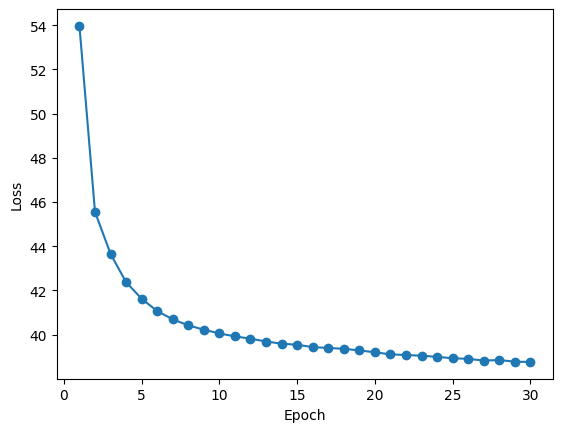

In [10]:
# plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

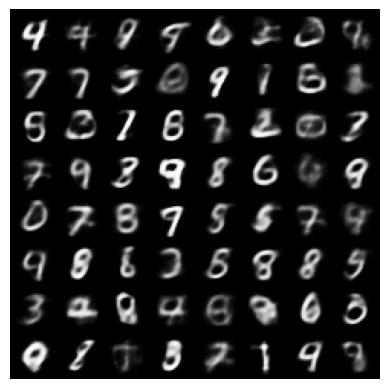

In [12]:
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()